In [14]:
%matplotlib notebook
from scapy.all import *
from pprint import pprint
import sys
import numpy as np
import os
import dpkt
import matplotlib.pyplot as plt

KEYLEN=8

VALUE_PKT_SIZE = 591
GET_PKT_SIZE = 64
MAX_LINE_RATE =10e9

GET_SET_RATIO = .9

In [15]:
def read_pcap(out_dir, dst_mac_is_ts = True, try_compare_counters = True):
    
    if try_compare_counters:
        count_file = os.path.join(out_dir, 'counters_0.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_start_pkts = int(n_pkts_str[:-1])
        count_file = os.path.join(out_dir, 'counters_1.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_end_pkts = int(n_pkts_str[:-1])   
        n_expected_pkts = (n_end_pkts - n_start_pkts)
        
        print("Expecting {} packets".format(n_expected_pkts))
                
    pcf = os.path.join(out_dir, 'moongen', 'new_moongen.pcap')
    
    counters = {
        'oset': 0,
        'iset': 0,
        'miss': 0,
        'oget': 0,
        'iget': 0,
        'ovalue': 0,
        'ivalue': 0,
        'unreach': 0,
        'other': 0,
        'stored': 0
    }
    
    gets = defaultdict(list)
    vals = defaultdict(list)
    sets = defaultdict(list)
    storeds = defaultdict(list)
    pkt_ithroughput = []
    pkt_ithroughput.append(1000)
    pkt_ithroughput.append(2000)
    pkt_othroughput = []
    pkt_othroughput.append(1000)
    pkt_othroughput.append(2000)
    

    f = open(pcf, 'rb')
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    total_isize = 0
    total_osize = 0
    for ts, buf in pcap:
        try:
            eth=dpkt.ethernet.Ethernet(buf)
            eth.type = 0x0800
            ip=eth.data
            
            udp = ip.data
            spkt = udp.data
        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            Ether(buf).show2()
            raise

        if dst_mac_is_ts:
            x3, x2, x1 = struct.unpack("!HHH", eth.dst)
            ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
            
            if eth.src == b'\x00\x00\x00\x00\x00\x01':
                if ts <= pkt_othroughput[0]:
                    pkt_othroughput[0] = ts
                pkt_othroughput[1] = ts
                
            elif eth.src == b'\x00\x00\x00\x00\x00\x02':
                if ts <= pkt_ithroughput[0]:
                    pkt_ithroughput[0] = ts
                pkt_ithroughput[1] = ts                
                
        get_start = spkt.find(b'get ')
        if get_start >= 0:
            #key = spkt[:2] + spkt[get_start+4:get_start+4+KEYLEN]
            #gets[key].append(ts)
            if eth.src == b'\x00\x00\x00\x00\x00\x01':
                counters['oget'] += 1
                total_osize += ip.len + 14
                
            elif eth.src == b'\x00\x00\x00\x00\x00\x02':
                counters['iget'] += 1
                total_isize += ip.len + 14
            continue
        val_start = spkt.find(b'VALUE ')
        if val_start >= 0:
            #key = spkt[:2] + spkt[val_start+6:val_start+6+KEYLEN]
            #vals[key].append((ts, ip.id))
                
            if eth.src == b'\x00\x00\x00\x00\x00\x01':
                counters['ovalue'] += 1
                total_osize += ip.len + 14
            elif eth.src == b'\x00\x00\x00\x00\x00\x02':
                counters['ivalue'] += 1
                total_isize += ip.len + 14
            continue
        if b'set ' in spkt:
            #key = spkt[:2]
            #sets[key].append(ts)
                
            if eth.src == b'\x00\x00\x00\x00\x00\x01':
                counters['oset'] += 1
                total_osize += ip.len + 14
            elif eth.src == b'\x00\x00\x00\x00\x00\x02':
                counters['iset'] += 1
                total_isize += ip.len + 14
                
        elif b'STORED' in spkt:
            #key = spkt[:2]
            #storeds[key].append((ts, ip.id))
            counters['stored'] += 1
            continue
        elif b'END' in spkt:
            counters['miss'] += 1
        else:
            counters['other'] += 1
            print('Unknown packet load: {}'.format(buf))
            
            
    print("Finished reading pcap: ")
    pprint(counters)
    print("Total input bytes: " + str(total_isize))
    print("Total output bytes: " + str(total_osize))
    print("Input throughput start, end: " + str(pkt_ithroughput))
    print("Output start, end " + str(pkt_othroughput))
    
    in_tput = ((total_isize * 8) / (pkt_ithroughput[1] - pkt_ithroughput[0]))
    out_tput = ((total_osize * 8) / (pkt_othroughput[1] - pkt_othroughput[0]))
    
    print("Input throughput " + str(in_tput))
    print("Output throughput " + str(out_tput))
    
    ipps = (n_expected_pkts/2) / ((pkt_ithroughput[1] - pkt_ithroughput[0]))
    opps = (n_expected_pkts/2) / ((pkt_othroughput[1] - pkt_othroughput[0]))
    
    print("Input pps: " + str(ipps))
    print("Output pps: " + str(opps))
    
    if eth.src == b'\x00\x00\x00\x00\x00\x01':
        if ( counters['oget'] != 98 or counters['ovalue'] != 642
             or counters['oset'] != 260 ) \
                and try_compare_counters:
            n_got_pkts = sum(counters.values())
            if n_got_pkts < (n_expected_pkts / 2):
                print("******************\n"*5 + \
                      "GOT {} PKTS, EXPECTED {}\n".format(n_got_pkts, n_expected_pkts/2) +\
                      "******************\n"*5
                     )
    elif eth.src == b'\x00\x00\x00\x00\x00\x02':
        if ( counters['iget'] != 98
             or counters['iset'] != 902 ) \
                and try_compare_counters:
            n_got_pkts = sum(counters.values())
            if n_got_pkts < (n_expected_pkts / 2):
                print("******************\n"*5 + \
                      "GOT {} PKTS, EXPECTED {}\n".format(n_got_pkts, n_expected_pkts/2) +\
                      "******************\n"*5
                     )
    #return gets, vals, sets, storeds, total_size


In [16]:
 

def get_latency(out_dir, dst_mac_is_ts=True):

    pkt_latency = []
    
    pcf = os.path.join(out_dir, 'moongen', 'new_moongen.pcap')
    
    counters = {
        'ingress': 0,
        'egress': 0,
    }

    f = open(pcf, 'rb')
    
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    total_size = 0
    pkt_ingress = []
    pkt_egress = []
    
    
    for ts, buf in pcap:
        try:
            eth=dpkt.ethernet.Ethernet(buf)
            
            #ip=eth.data
            
            #TODO: Add a check to distinguish ingress and egress packets
            # If ingress, add to input array.
            # If egress, add to output array
            
            if eth.src == b'\x00\x00\x00\x00\x00\x01':
                counters['egress'] += 1
            elif eth.src == b'\x00\x00\x00\x00\x00\x02':    
                counters['ingress'] += 1
            else:
                continue
            

            if dst_mac_is_ts:
                x3, x2, x1 = struct.unpack("!HHH", eth.dst)
                ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
                
                if eth.src == b'\x00\x00\x00\x00\x00\x01':
                    pkt_egress.append(ts)
                elif eth.src == b'\x00\x00\x00\x00\x00\x02':    
                    pkt_ingress.append(ts)

                
        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            Ether(buf).show2()
            raise
     
    print("counters[ingress]" + str(counters['ingress']))
    print("counters[egress]" + str(counters['egress']))
    
    length = len(pkt_ingress)
    
    i = 0
    if length == 10000:
        while (i < length):
            pkt_latency.append(pkt_egress[i] - pkt_ingress[i])
            i += 1
        
    i = 0
    tot = 0
    
    
    
    for val in pkt_latency:
        tot += val
    
    print(tot)
    print(length)
    avg = tot / length

    print(avg)
    
    plt.figure()
    plt.plot(pkt_latency,'.')
    #y = 0
    #while y < length:
     #   y = y + 1;
      #  plt.plot(y, 10, '.')
        
        
        
    #print(pkt_ingress[0])
    #print(pkt_ingress[length - 1])
    #print(pkt_egress[0])
    #print(pkt_egress[length - 1])
    #return pkt_latency

Expecting 20000 packets
Reading /home/ncshy/P4Boosters/testing/memcached/execution/test_rerun/fpga_inline_cache_rerun2/fpga_inline_cache_rerun2_33.00/moongen/new_moongen.pcap
Finished reading pcap: 
{'iget': 9004,
 'iset': 996,
 'ivalue': 0,
 'miss': 0,
 'oget': 4564,
 'oset': 996,
 'other': 0,
 'ovalue': 4440,
 'stored': 0,
 'unreach': 0}
Total input bytes: 1160908
Total output bytes: 3500788
Input throughput start, end: [41.767979413, 41.771501259000004]
Output start, end [41.767985346, 41.771505288]
Input throughput 2637044322.774507
Output throughput 7956467464.527628
Input pps: 2839420.0087070926
Output pps: 2840955.902116762
Reading /home/ncshy/P4Boosters/testing/memcached/execution/test_rerun/fpga_inline_cache_rerun2/fpga_inline_cache_rerun2_33.00/moongen/new_moongen.pcap
counters[ingress]10000
counters[egress]10000
0.26266365100022426
10000
2.6266365100022425e-05


<IPython.core.display.Javascript object>


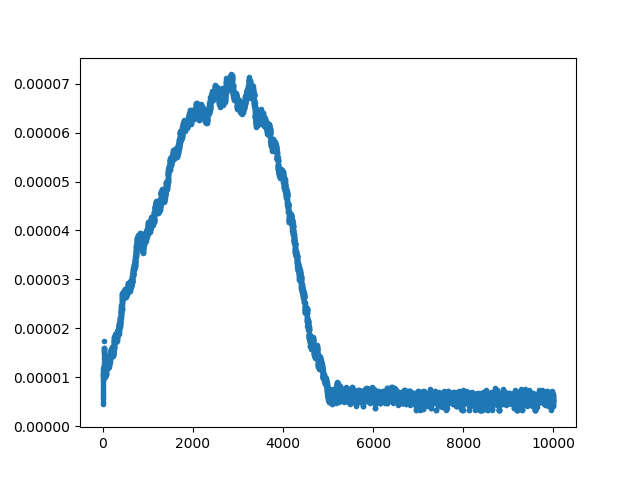

In [19]:
out_dir = "/home/ncshy/P4Boosters/testing/memcached/execution/test_rerun/fpga_inline_cache_rerun2/fpga_inline_cache_rerun2_33.00/"
read_pcap(out_dir, True, True)
pkt_latency = get_latency(out_dir, True)